In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

get_ipython().run_line_magic('matplotlib', 'inline')

import warnings
warnings.filterwarnings("ignore")

sns.color_palette("husl")
sns.set_style('darkgrid')

In [2]:
# 1.1 Adstock
def apply_adstock(x, L, P, D):
    '''
    params:
    x: original media variable, array
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    '''
    x = np.append(np.zeros(L-1), x)
    
    weights = np.zeros(L)
    for l in range(L):
        weight = D**((l-P)**2)
        weights[L-1-l] = weight
    
    adstocked_x = []
    for i in range(L-1, len(x)):
        x_array = x[i-L+1:i+1]
        xi = sum(x_array * weights)/sum(weights)
        adstocked_x.append(xi)
    adstocked_x = np.array(adstocked_x)
    return adstocked_x

In [3]:
# Gather posterior data
def posterior_data( parameters, mmm1_A, mmm1_B ):
    n_draws = len(mmm1_A['peak_list'])
    frames = []
    for param, var in zip(parameters['A']['param'],parameters['A']['cols']):
        data=np.array(mmm1_A[param])
        frames.append(pd.DataFrame(data[:,0:len(mmm1_A[var])], columns=mmm1_A[var]  ) )
    data_A =pd.concat(frames,axis=1)

    frames = []
    for param, var in zip(parameters['B']['param'],parameters['B']['cols']):
        data=np.array(mmm1_B[param])
        frames.append(pd.DataFrame(data[:,0:len(mmm1_B[var])], columns=mmm1_B[var] ))
    data_B =pd.concat(frames,axis=1)

    df_models = pd.concat([data_A,data_B],axis=0)

    df_models['model'] = ['A']*n_draws + ['B']*n_draws
    df_models.reset_index(inplace=True)

    media_columns = list(set(data_B.columns).intersection(data_A.columns))

    df_models = df_models.loc[:,media_columns + ['model']]
    return df_models

Load trained media model with shorter peak delays on SEM, Instagram, Video

In [4]:
dir = Path.cwd()
with open(dir.joinpath('mmm1_A.json'), 'r') as fpA, open(dir.joinpath('mmm1_B.json'), 'r') as fpB:
    mmm1_B = json.load(fpB)
    mmm1_A = json.load(fpA)

### New priors on peak and beta for different channels;
#### Peak
 * SEM, Video (traditional), Instagram parameters: Strong prior: normal( mean = 0, std = 0.5 )
 * The rest: uninformative prior: uniform 0 to 4 weeks
#### Beta
 * SEM, Video (traditional), Instagram parameters: Strong prior relative to the rest: normal( mean = 0, std = 0.2 )
 * The rest: weak prior: normal( mean = 0, std = 1 )

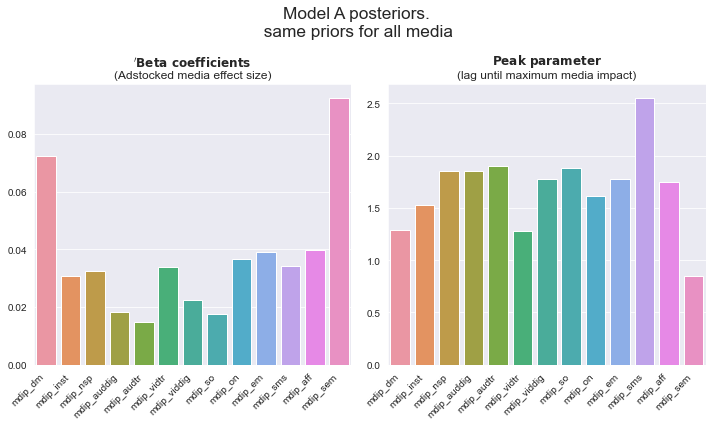

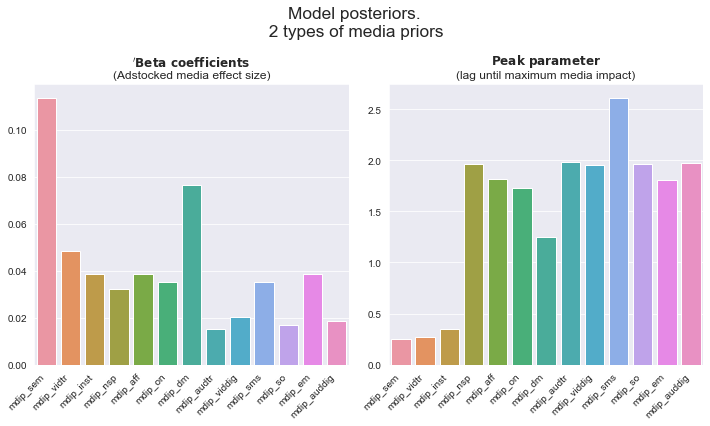

In [5]:
f, axs = plt.subplots(nrows=1,ncols=2, figsize=(10,6))
sns.barplot( y = mmm1_A['beta'][:-1], x =  mmm1_A['media_vars'], ax=axs[0] )
_ = plt.setp(axs[0].get_xticklabels(), rotation=45, ha='right')
_ = axs[0].set_title(r"$\bf{'Beta\ coefficients}$" +"\n(Adstocked media effect size)")

sns.barplot( y = mmm1_A['peak'], x =  mmm1_A['media_vars'], ax = axs[1] )
_ = plt.setp(axs[1].get_xticklabels(), rotation=45, ha='right')
_ = axs[1].set_title(r"$\bf{Peak\ parameter}$" +"\n(lag until maximum media impact)")
plt.suptitle('Model A posteriors.\n same priors for all media',fontsize='xx-large')
plt.tight_layout()
plt.show()

f, axs = plt.subplots(nrows=1,ncols=2, figsize=(10,6))
sns.barplot( y = mmm1_B['beta2'] + mmm1_B['beta'][:-1], x = mmm1_B['fast_media_vars'] + mmm1_B['media_vars'], ax=axs[0])
_ = plt.setp(axs[0].get_xticklabels(), rotation=45, ha='right')
_ = axs[0].set_title(r"$\bf{'Beta\ coefficients}$" +"\n(Adstocked media effect size)")

sns.barplot( y = mmm1_B['peak2'] + mmm1_B['peak'], x = mmm1_B['fast_media_vars'] + mmm1_B['media_vars'], ax = axs[1] )
_ = plt.setp(axs[1].get_xticklabels(), rotation=45, ha='right')
_ = axs[1].set_title(r"$\bf{Peak\ parameter}$" +"\n(lag until maximum media impact)")
plt.suptitle('Model posteriors.\n 2 types of media priors',fontsize='xx-large')
plt.tight_layout()
plt.show()

Model B has very strong prior on how quickly Instagram marketing effect decays

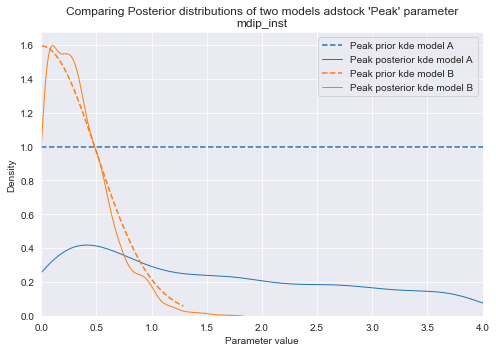

In [6]:
parameters = {'A':{'param':['peak_list'],'cols':['media_vars']},
              'B':{'param':['peak_list','peak2_list'], 'cols':['media_vars','fast_media_vars']} }

df_models_peak = posterior_data(parameters, mmm1_A=mmm1_A, mmm1_B=mmm1_B)

fig,ax = plt.subplots(figsize=(7,5))
media = 'mdip_inst'

color_blue = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1)
blue_1 = 'Peak prior kde model A'
ax.axhline(1, color=color_blue, linestyle='--', label=blue_1)

blue_2 = 'Peak posterior kde model A'
sns.kdeplot(data=df_models_peak.loc[df_models_peak.model=='A', media],
            color= color_blue,
            lw=1,
            label=blue_2,
            ax=ax)

color_orange = (1.0, 0.4980392156862745, 0.054901960784313725, 1)
orange_1 = 'Peak prior kde model B'
rv = stats.halfnorm(0, 0.5)
pdf_x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
pdf = rv.pdf(pdf_x)
plt.plot(pdf_x,pdf, '--',color=color_orange, axes=ax, label=orange_1)

orange_2 = 'Peak posterior kde model B'
sns.kdeplot(data=df_models_peak.loc[df_models_peak.model=='B', media],
            color= color_orange,
            lw=1,
            label=orange_2,
            ax=ax)

ax.set_xlim([0,4])
ax.set_xlabel('Parameter value')
ax.set_title("Comparing Posterior distributions of two models adstock 'Peak' parameter\n{}".format(media), fontdict={'fontsize':12})
ax.legend()
plt.tight_layout()

Plot Adstock curves

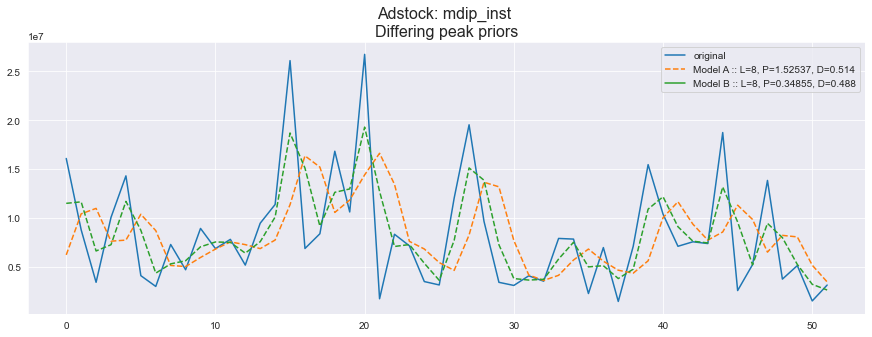

In [7]:
df = pd.read_csv(dir.parent.joinpath('data.csv'),usecols=['mdip_sem','mdip_vidtr','mdip_inst'])

channel = 'mdip_inst'
xm = df[channel].values

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x=range(52), y=xm[-52:], ax=ax, label='original')

i, model_name = 0, 'A'
ii = mmm1_A['media_vars'].index(channel)
P = mmm1_A['peak'][ii]
L = mmm1_A['max_lag']
D = mmm1_A['decay'][ii]
xm_adstocked = apply_adstock(xm, L, P, D)
sns.lineplot(x=range(52), y=xm_adstocked[-52:], ax=ax, 
                label='Model %s :: L=%d, P=%.5f, D=%.3f'%(model_name, L, P, D))
ax.lines[i+1].set_linestyle("--")

i, model_name = 1, 'B'
ii = mmm1_B['fast_media_vars'].index(channel)
P = mmm1_B['peak2'][ii]
L = mmm1_B['max_lag']
D = mmm1_B['decay2'][ii]
xm_adstocked = apply_adstock(xm, L, P, D)
sns.lineplot(x=range(52), y=xm_adstocked[-52:], ax=ax, 
                label='Model %s :: L=%d, P=%.5f, D=%.3f'%(model_name, L, P, D))
ax.lines[i+1].set_linestyle("--")

_ = ax.set_title('Adstock: %s \nDiffering peak priors' % channel, fontsize=16)

Compare two models' posterior distributions: Peak

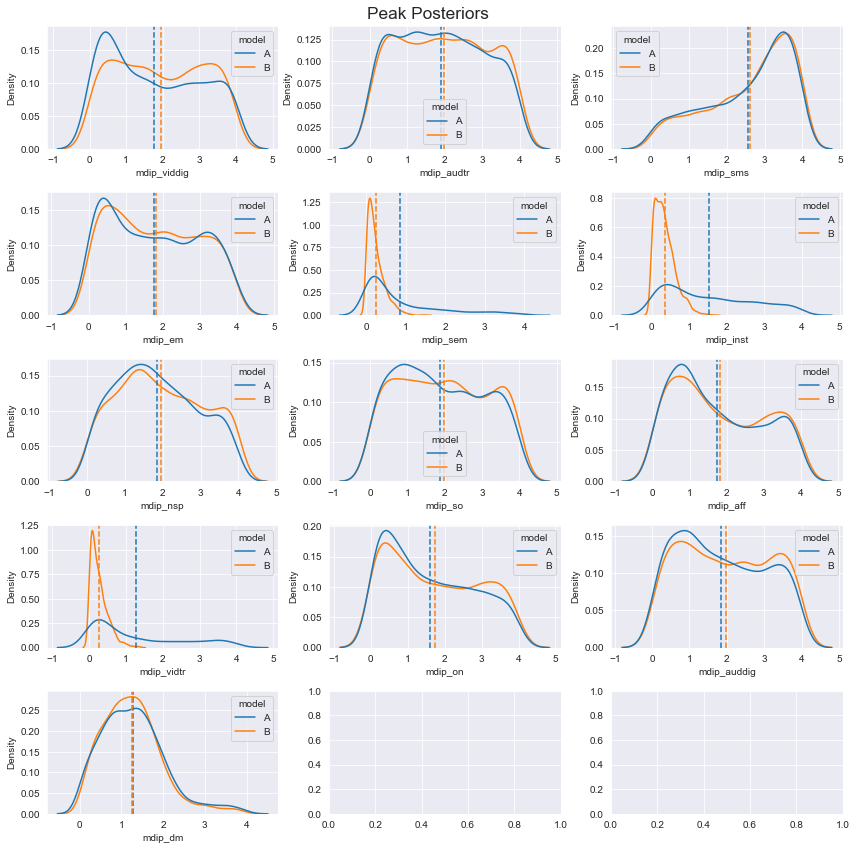

In [15]:

def plot_posteriors(parameters,mmm_A, mmm_B, title):
                    
    df_models = posterior_data( parameters, mmm_A, mmm_B )

    fig, axes = plt.subplots(5, 3, figsize=(12,12))
    axes = axes.ravel()  

    for col, ax in zip( [col for col in df_models.columns if col!='model'] , axes):
        sns.kdeplot(data=df_models[[col,'model']],x=col, hue='model', ax=ax )
        orange, blue = (l.get_color() for l in ax.get_children()[:2])

        mean_A = df_models.loc[df_models.model=='A',col].mean()
        mean_B = df_models.loc[df_models.model=='B',col].mean()
        ax.axvline(mean_A, color=blue, linestyle='--')
        ax.axvline(mean_B, color=orange, linestyle='--')

    plt.suptitle(title, fontsize='xx-large') 
    fig.tight_layout()
    plt.show()

plot_posteriors(parameters = {'A':{'param':['peak_list'],'cols':['media_vars']},
                              'B':{'param':['peak_list','peak2_list'], 'cols':['media_vars','fast_media_vars']} },
                title = 'Peak Posteriors',
                mmm_A = mmm1_A, 
                mmm_B = mmm1_B)

Compare two models' posterior distributions: beta

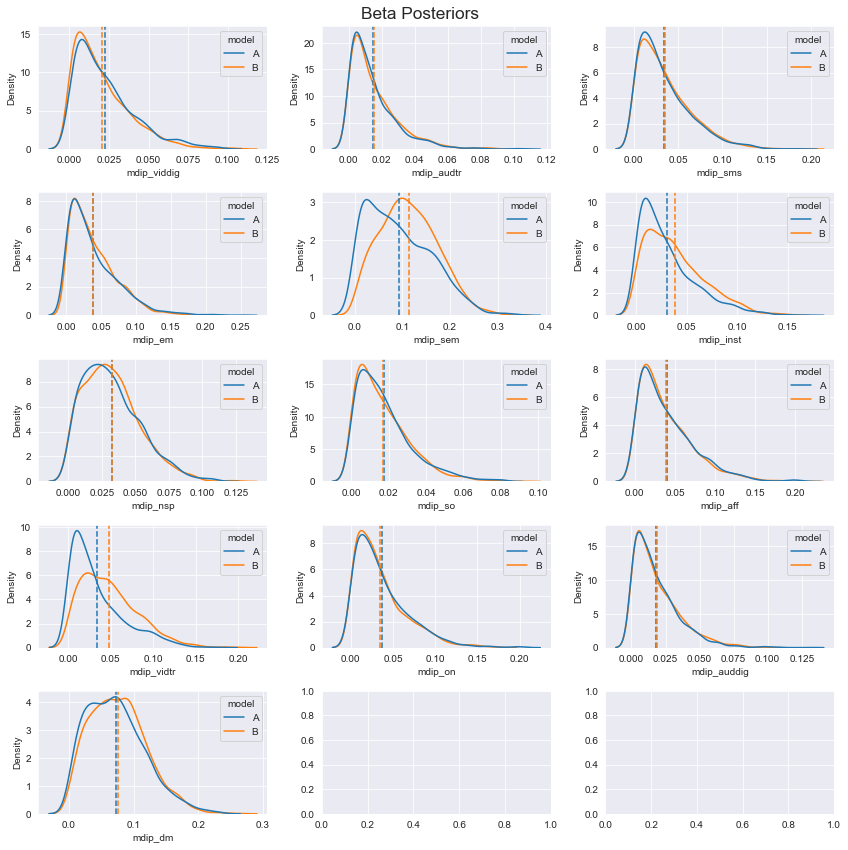

In [16]:
plot_posteriors(parameters = {'A':{'param':['beta_list'],'cols':['media_vars']},
                              'B':{'param':['beta_list','beta2_list'], 'cols':['media_vars','fast_media_vars']} },
                title = 'Beta Posteriors',
                mmm_A = mmm1_A, 
                mmm_B = mmm1_B)

### Posteriors: Model A (Beta)

In [17]:
def plot_coefficients_distributions( mmm, column_group, parameter='beta_list'):
    # plot media coefficients' distributions
    # red line: mean, green line: median
    beta_media = {}
    for i in range(len(mmm[column_group])):
        md = mmm[column_group][i]
        betas = []
        for j in range(len(mmm[parameter])):
            betas.append(mmm[parameter][j][i])
        beta_media[md] = np.array(betas)

    f = plt.figure(figsize=(12,10))
    for i in range(len(mmm[column_group])):
        ax = f.add_subplot(5,3,i+1)
        md = mmm[column_group][i]
        x = beta_media[md]
        mean_x = x.mean()
        median_x = np.median(x)
        ax = sns.distplot(x)
        ax.axvline(mean_x, color='r', linestyle='-')
        ax.axvline(median_x, color='g', linestyle='-')
        ax.set_title(md)
    plt.suptitle(parameter)
    plt.tight_layout()

Text(0.5, 0.98, 'Beta values: all media')

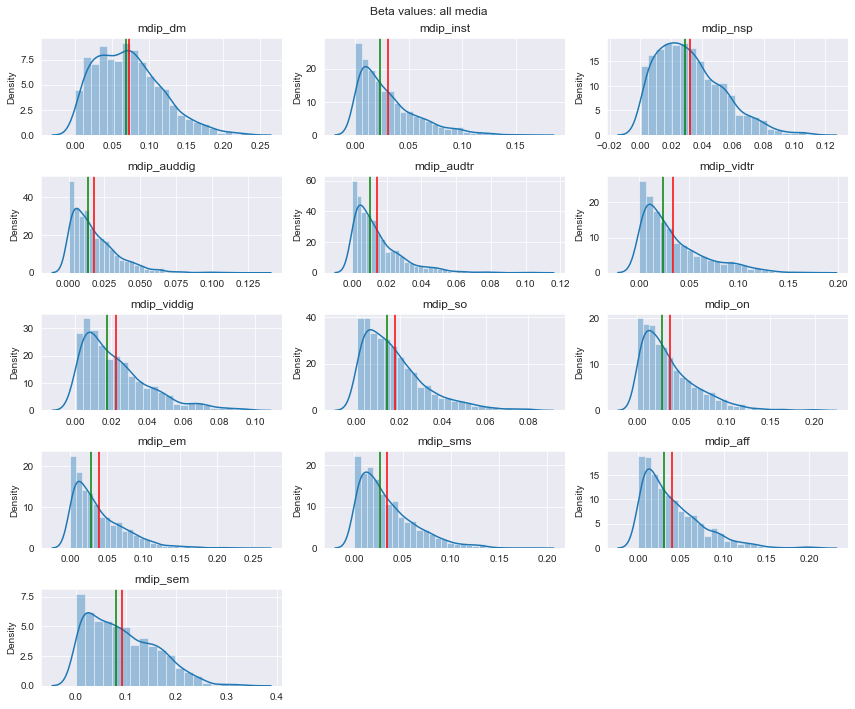

In [18]:
plot_coefficients_distributions( mmm = mmm1_A, column_group ='media_vars', parameter='beta_list')
plt.suptitle('Beta values: all media', fontdict={'size':20})

### Posteriors: Model A (Peak)

Text(0.5, 0.98, 'Peak values: all media')

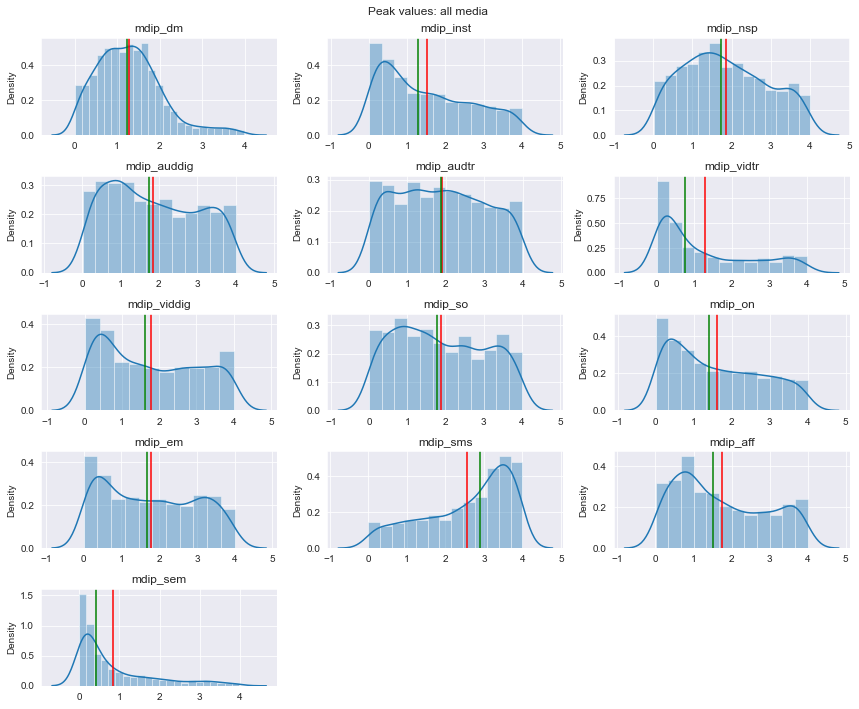

In [19]:
plot_coefficients_distributions( mmm = mmm1_A, column_group ='media_vars', parameter='peak_list')
plt.suptitle('Peak values: all media', fontdict={'size':20})

### Posteriors by media group: Model B (Beta)

Text(0.5, 0.98, 'Beta values: all other media')

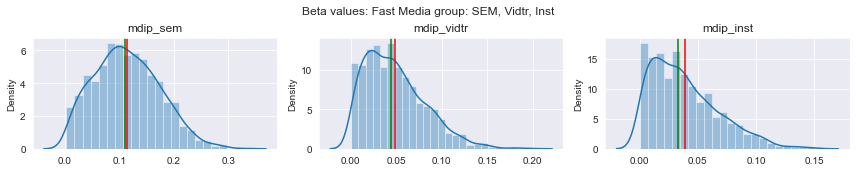

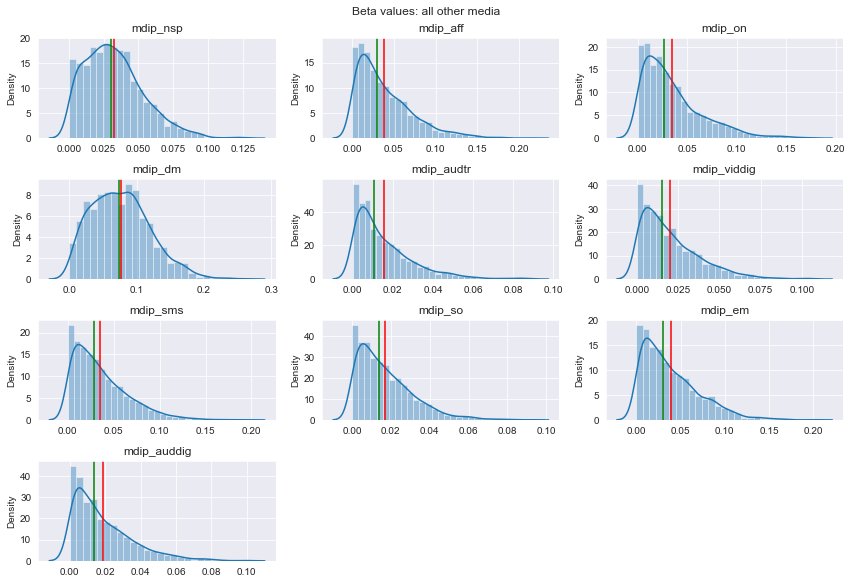

In [20]:
plot_coefficients_distributions( mmm = mmm1_B, column_group ='fast_media_vars', parameter='beta2_list')
plt.suptitle('Beta values: Fast Media group: SEM, Vidtr, Inst', fontdict={'size':20})
plot_coefficients_distributions( mmm = mmm1_B, column_group ='media_vars', parameter='beta_list')
plt.suptitle('Beta values: all other media', fontdict={'size':20})

### Posteriors by media group: Model B (Peak)

Text(0.5, 0.98, 'Peak values: all other media')

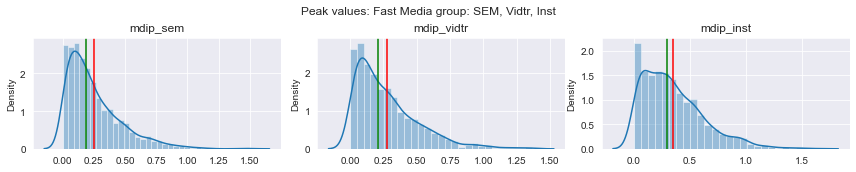

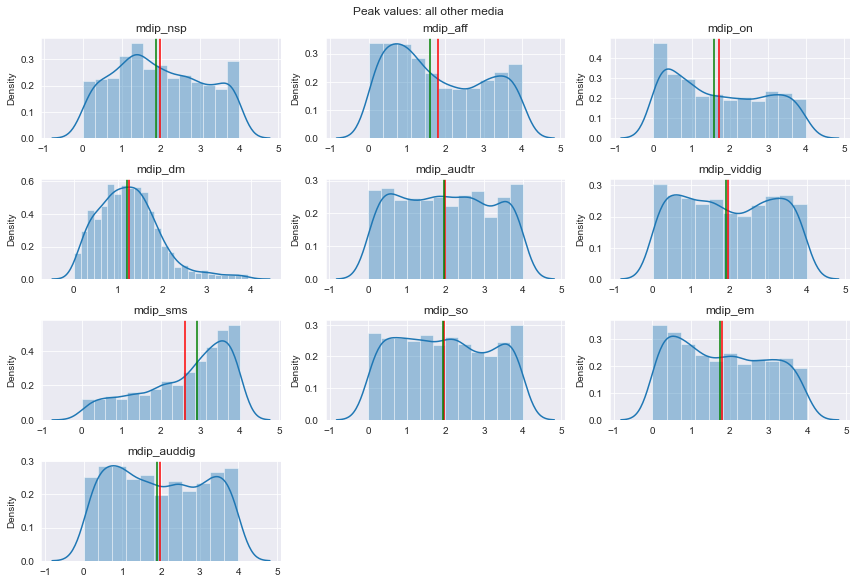

In [21]:
plot_coefficients_distributions( mmm = mmm1_B, column_group ='fast_media_vars', parameter='peak2_list')
plt.suptitle('Peak values: Fast Media group: SEM, Vidtr, Inst', fontdict={'size':20})
plot_coefficients_distributions( mmm = mmm1_B, column_group ='media_vars', parameter='peak_list')
plt.suptitle('Peak values: all other media', fontdict={'size':20})